In [1]:
pip install scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [2]:
import allel
import numpy as np
from sklearn import decomposition
import pandas as pd

In [3]:
vcf_filename = r"C:\Users\leosz\OneDrive\Desktop\Bioinfor_genes\ALL.chr22.phase1_release_v3.20101123.snps_indels_svs.genotypes.vcf.gz"
panel_filename = r"C:\Users\leosz\OneDrive\Desktop\Bioinfor_genes\ALL.chr22.phase1_release_v3.20101123.snps_indels_svs.genotypes.vcf\phase1_integrated_calls.20101123.ALL.panel"


In [4]:



data = allel.read_vcf(vcf_filename, fields=['samples', 'calldata/GT', 'variants/ID'])

# Verificar se os campos foram carregados corretamente
if 'calldata/GT' not in data:
    raise ValueError("O arquivo VCF não contém informações de genótipo (calldata/GT).")

genotypes = data['calldata/GT']  # Shape esperado: (num_variants, num_samples, ploidy)
samples = data.get('samples', [])  # Pode ser vazio se não houver amostras
variant_ids = data.get('variants/ID', [])  # Pode ser vazio se não houver variantes

# Verificar formato de genotypes
if genotypes.ndim != 3:
    raise ValueError(f"Formato inesperado de genotypes: {genotypes.shape}")

# Convertendo genótipos de tuplas para contagens de alelos alternativos
genotypes = np.sum(genotypes, axis=2)  # Somar ao longo da dimensão ploidy

# Verificar as dimensões após conversão
print(f'Genótipos processados: {genotypes.shape}')  # Deve ser (num_variants, num_samples)

# Carregar os rótulos de população do painel
labels = {}
with open(panel_filename) as panel_file:
    for line in panel_file:
        line = line.strip().split('\t')
        if len(line) >= 2:
            labels[line[0]] = line[1]

# Criar a matriz de variantes
if genotypes.size == 0:
    raise ValueError("Nenhum dado genético disponível após o processamento.")

matrix = genotypes.T  # Transpor para que amostras sejam linhas e variantes sejam colunas

# Verificar dimensões antes de aplicar PCA
num_samples, num_variants = matrix.shape
print(f'Matriz final - Amostras: {num_samples}, Variantes: {num_variants}')

if num_samples > 1 and num_variants > 1:
    # Aplicar PCA
    pca = decomposition.PCA(n_components=2)
    pca.fit(matrix)
    print(f'Valores singulares do PCA: {pca.singular_values_}')
    to_plot = pca.transform(matrix)
    print(f'Formato da projeção PCA: {to_plot.shape}')

    # Criar um DataFrame para salvar a matriz
    df = pd.DataFrame(matrix, columns=variant_ids, index=samples)
    df['Population code'] = df.index.map(labels)

    # Salvar a matriz como CSV
    df.to_csv("matrix.csv")
else:
    print("Número insuficiente de amostras ou variantes para realizar PCA.")

Genótipos processados: (494328, 1092)
Matriz final - Amostras: 1092, Variantes: 494328
Valores singulares do PCA: [1916.8335393  1541.39627568]
Formato da projeção PCA: (1092, 2)


In [7]:
pip install pyarrow


   ---------------------------------------- 0.0/25.2 MB ? eta -:--:--
   --------- ------------------------------ 6.0/25.2 MB 30.7 MB/s eta 0:00:01
   --------------------------- ------------ 17.3/25.2 MB 45.4 MB/s eta 0:00:01
   ---------------------------------------- 25.2/25.2 MB 47.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [10]:
df = pd.read_csv("matrix.csv", low_memory=False)  # Evita divisão de colunas em múltiplos tipos


In [ ]:
#df=pd.read_csv("matrix.csv")


In [11]:
df.shape

(1092, 494330)

In [14]:
df['Sample'] = df.index

In [15]:
df.reset_index(inplace=True)

In [17]:
df.drop('index', axis=1,inplace=True)

,Unnamed: 0,rs149201999,rs146752890,rs139377059,rs188945759,rs6518357,rs62224609,rs62224610,rs143503259,rs192339082,...,rs200507571,rs3896457,rs183661957,rs188271599,rs149733995,rs143849140,rs140611932,rs181833046,Population code,Sample
0,HG00096,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,GBR,0
1,HG00097,1,1,1,0,1,1,1,1,0,...,0,1,0,0,0,0,0,0,GBR,1
2,HG00099,1,1,1,0,1,1,1,1,0,...,0,0,0,0,2,0,0,0,GBR,2


In [19]:
df.drop('Sample', axis=1,inplace=True)

In [22]:
df.rename(columns={'Unnamed: 0': 'Sample'}, inplace=True)

In [23]:
df.head(3)

,Sample,rs149201999,rs146752890,rs139377059,rs188945759,rs6518357,rs62224609,rs62224610,rs143503259,rs192339082,...,rs201907533,rs200507571,rs3896457,rs183661957,rs188271599,rs149733995,rs143849140,rs140611932,rs181833046,Population code
0,HG00096,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,GBR
1,HG00097,1,1,1,0,1,1,1,1,0,...,0,0,1,0,0,0,0,0,0,GBR
2,HG00099,1,1,1,0,1,1,1,1,0,...,0,0,0,0,0,2,0,0,0,GBR


In [24]:
non_snp_columns = ['Population code', 'Sample']

In [25]:
df_snps = df.drop(non_snp_columns, axis=1)
matrix = df_snps.to_numpy()
print(matrix.shape)
matrix

(1092, 494328)


array([[0, 1, 0, ..., 0, 0, 1],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]])

In [26]:
from sklearn import decomposition

In [27]:
pca = decomposition.PCA(n_components=2)
pca.fit(matrix)

PCA(n_components=2)

In [28]:
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.08483541 0.05485762]
[1916.8335393  1541.39627568]


In [29]:
to_plot = pca.transform(matrix)
to_plot.shape

(1092, 2)

In [30]:
#pip install matplotlib

In [31]:
import matplotlib.pyplot as plt

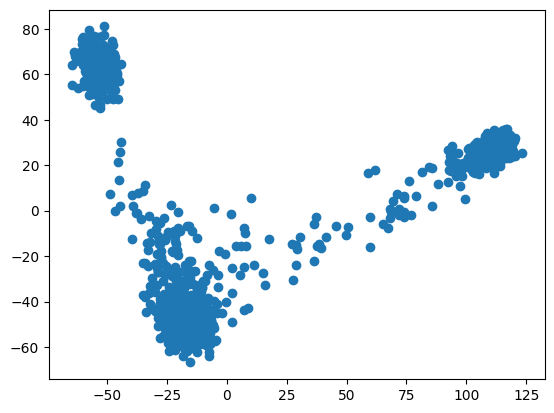

In [72]:
plt.scatter(x=to_plot[:, 0], y=to_plot[:, 1])


In [71]:

# Ajustar limites dos eixos
plt.xlim(min(to_plot[:, 0]), max(to_plot[:, 0]))
plt.ylim(min(to_plot[:, 1]), max(to_plot[:, 1]))

# Adicionar títulos e rótulos
plt.title("PCA Scatter Plot")
plt.xlabel("PC1")
plt.ylabel("PC2")

# Salvar a imagem
plt.savefig("PCA_1.png")
plt.close()


In [33]:
to_plot.shape

(1092, 2)

In [34]:
#pip install altair

In [35]:
import altair as alt

In [36]:
df_plot = df[non_snp_columns].copy()
df_plot

,Population code,Sample
0,GBR,HG00096
1,GBR,HG00097
2,GBR,HG00099
3,GBR,HG00100
4,GBR,HG00101
...,...,...
1087,TSI,NA20816
1088,TSI,NA20818
1089,TSI,NA20819
1090,TSI,NA20826


In [37]:
df_plot['PC1'] = to_plot[:, 0]
df_plot['PC2'] = to_plot[:, 1]
df_plot

,Population code,Sample,PC1,PC2
0,GBR,HG00096,-12.627579,-53.129873
1,GBR,HG00097,-21.336461,-49.187882
2,GBR,HG00099,-13.158043,-52.792577
3,GBR,HG00100,-15.677305,-56.723408
4,GBR,HG00101,-14.390443,-43.524291
...,...,...,...,...
1087,TSI,NA20816,-14.255908,-52.440315
1088,TSI,NA20818,-22.245645,-53.126219
1089,TSI,NA20819,-11.059276,-51.502161
1090,TSI,NA20826,-12.371652,-52.710636


In [77]:
chart = alt.Chart(df_plot).mark_point().encode(
    x='PC1',
    y='PC2',
    color=alt.Color('Population code', scale=alt.Scale(scheme='category20'))
)

In [73]:
chart

alt.Chart(...)

In [79]:
chart.save("PCA_paises.png")  # Salva no formato PNG


In [39]:
pop = pd.read_csv(r"C:\Users\leosz\OneDrive\Desktop\Bioinfor_genes\ALL.chr22.phase1_release_v3.20101123.snps_indels_svs.genotypes.vcf\igsr_populations.tsv", sep='\t')
pop.head(3)

,Population code,Population elastic ID,Population name,Population description,Population latitude,Population longitude,Superpopulation code,Superpopulation name,Superpopulation display colour,Superpopulation display order,Data collections
0,CHS,CHS,Southern Han Chinese,Han Chinese South,23.13333,113.266667,EAS,East Asian Ancestry,#778500,3,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
1,KHV,KHV,Kinh Vietnamese,"Kinh in Ho Chi Minh City, Vietnam",10.78000,106.680000,EAS,East Asian Ancestry,#778500,3,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
2,NaN,BrahminSGDP,Brahmin,Brahmin in India (SGDP),17.70000,83.300000,NaN,South Asia (SGDP),#008c1e,18,Simons Genome Diversity Project


In [40]:
df_plot = df_plot.merge(pop, on='Population code', how='inner')
df_plot

,Population code,Sample,PC1,PC2,Population elastic ID,Population name,Population description,Population latitude,Population longitude,Superpopulation code,Superpopulation name,Superpopulation display colour,Superpopulation display order,Data collections
0,GBR,HG00096,-12.627579,-53.129873,GBR,British,British in England and Scotland,52.486243,-1.890401,EUR,European Ancestry,#018ead,4,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
1,GBR,HG00097,-21.336461,-49.187882,GBR,British,British in England and Scotland,52.486243,-1.890401,EUR,European Ancestry,#018ead,4,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
2,GBR,HG00099,-13.158043,-52.792577,GBR,British,British in England and Scotland,52.486243,-1.890401,EUR,European Ancestry,#018ead,4,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
3,GBR,HG00100,-15.677305,-56.723408,GBR,British,British in England and Scotland,52.486243,-1.890401,EUR,European Ancestry,#018ead,4,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
4,GBR,HG00101,-14.390443,-43.524291,GBR,British,British in England and Scotland,52.486243,-1.890401,EUR,European Ancestry,#018ead,4,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1087,TSI,NA20816,-14.255908,-52.440315,TSI,Toscani,Toscani in Italy,42.100000,12.000000,EUR,European Ancestry,#018ead,4,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
1088,TSI,NA20818,-22.245645,-53.126219,TSI,Toscani,Toscani in Italy,42.100000,12.000000,EUR,European Ancestry,#018ead,4,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
1089,TSI,NA20819,-11.059276,-51.502161,TSI,Toscani,Toscani in Italy,42.100000,12.000000,EUR,European Ancestry,#018ead,4,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
1090,TSI,NA20826,-12.371652,-52.710636,TSI,Toscani,Toscani in Italy,42.100000,12.000000,EUR,European Ancestry,#018ead,4,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."


In [80]:
pais_continente = alt.Chart(df_plot).mark_point().encode(
    x='PC1',
    y='PC2',
    color=alt.Color('Superpopulation name', scale=alt.Scale(scheme='category20')),
    fill='Population code'
)

In [81]:
pais_continente

alt.Chart(...)

In [82]:
pais_continente.save("PCA_pais_continente.png")

In [83]:
continente = alt.Chart(df_plot).mark_point().encode(
    x='PC1',
    y='PC2',
    color=alt.Color('Superpopulation name', scale=alt.Scale(scheme='category20'))
)

In [85]:
continente

alt.Chart(...)

In [86]:
continente.save("PCA_continente.png")

In [ ]:
df_plot.to_excel('genes_ancestralidade.xlsx', index=False)


In [ ]:
df_plot